# Avalição Qualidade do Vinho

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

warnings.filterwarnings("ignore")

### Collecting Data

Por toda a base de dados de treino de teste para assim poder treinar e depois testar com uma base real

In [2]:
df_train = pd.read_csv("./datasets/vinhos/winequality-red.csv", sep=";")
df_test = pd.read_csv("./datasets/vinhos/winequality-white.csv", sep=";")

### Data Information

Fazendo uma pré análise dos dados validando todos os tipos de dados e as possibilidades de informações que há na base de dados

In [3]:
df_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [ ]:
# Pegando uma média de cada informação baseado na qualidade parar identificar algum padrão da base de dados
df_train.groupby(['quality']).mean()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,
3,8.360000,0.884500,0.171000,2.635000,0.122500,11.000000,24.900000,0.997464,3.398000,0.570000,9.955000
4,7.779245,0.693962,0.174151,2.694340,0.090679,12.264151,36.245283,0.996542,3.381509,0.596415,10.265094
5,8.167254,0.577041,0.243686,2.528855,0.092736,16.983847,56.513950,0.997104,3.304949,0.620969,9.899706
6,8.347179,0.497484,0.273824,2.477194,0.084956,15.711599,40.869906,0.996615,3.318072,0.675329,10.629519
7,8.872362,0.403920,0.375176,2.720603,0.076588,14.045226,35.020101,0.996104,3.290754,0.741256,11.465913
8,8.566667,0.423333,0.391111,2.577778,0.068444,13.277778,33.444444,0.995212,3.267222,0.767778,12.094444


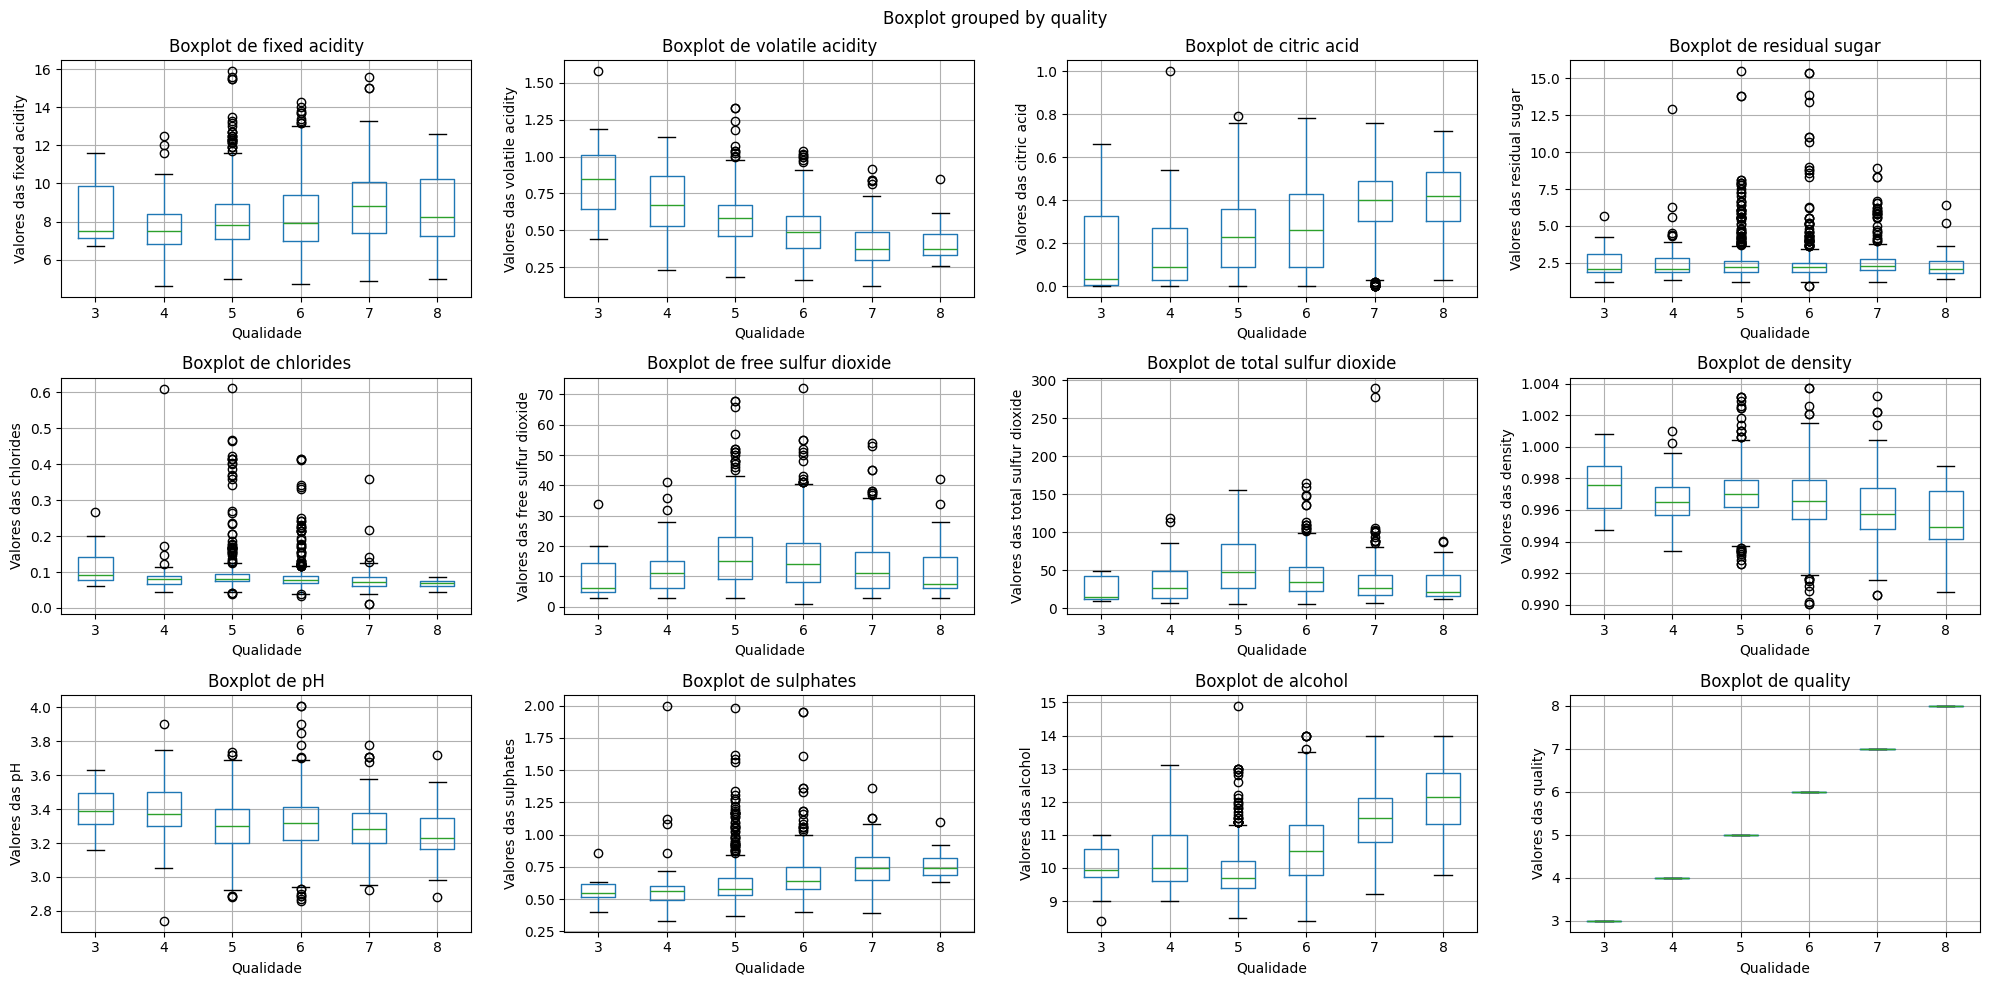

In [6]:
colunas = df_train.columns

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for i, coluna in enumerate(colunas):
    df_train.boxplot(column=coluna, by='quality',  ax=axes[i])
    axes[i].set_title(f'Boxplot de {coluna}')
    axes[i].set_xlabel('Qualidade')
    axes[i].set_ylabel(f'Valores das {coluna}')

plt.tight_layout()
plt.show()

In [7]:
# Vendo o tamanho da minha base baseado na minha qualidade
df_train.groupby(['quality']).size()

quality
3     10
4     53
5    681
6    638
7    199
8     18
dtype: int64

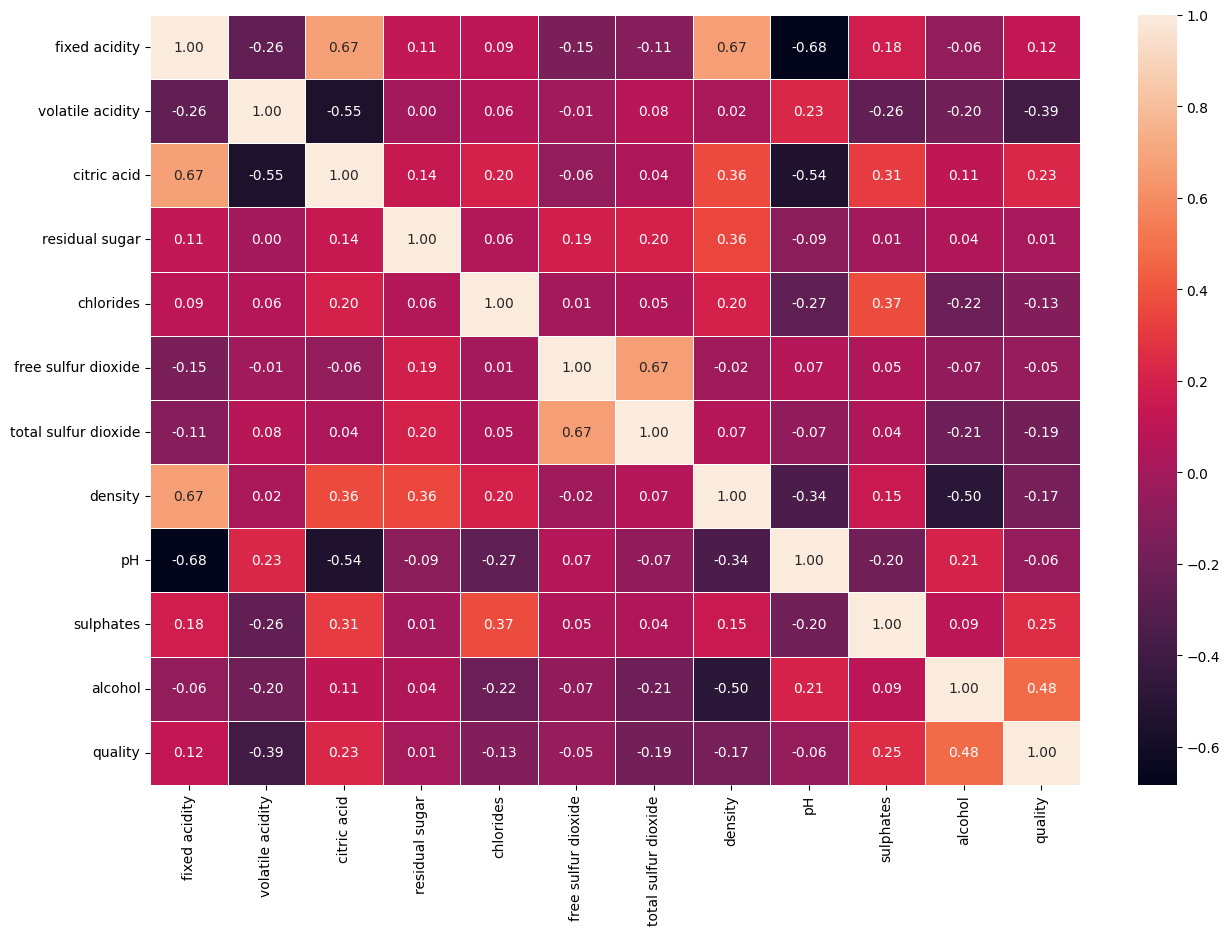

In [8]:
# Fazendo um gráfico de correlação para identificar alguma relação da minha base de dados
correlation = df_train.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation, annot=True, fmt='.2f', linewidth=0.5)
plt.show()

### Plots and Visualization

In [9]:
var_model = ['fixed acidity', 'volatile acidity', 'citric acid','chlorides','density','sulphates', 'alcohol']
X = df_train[var_model]
target = df_train['quality']

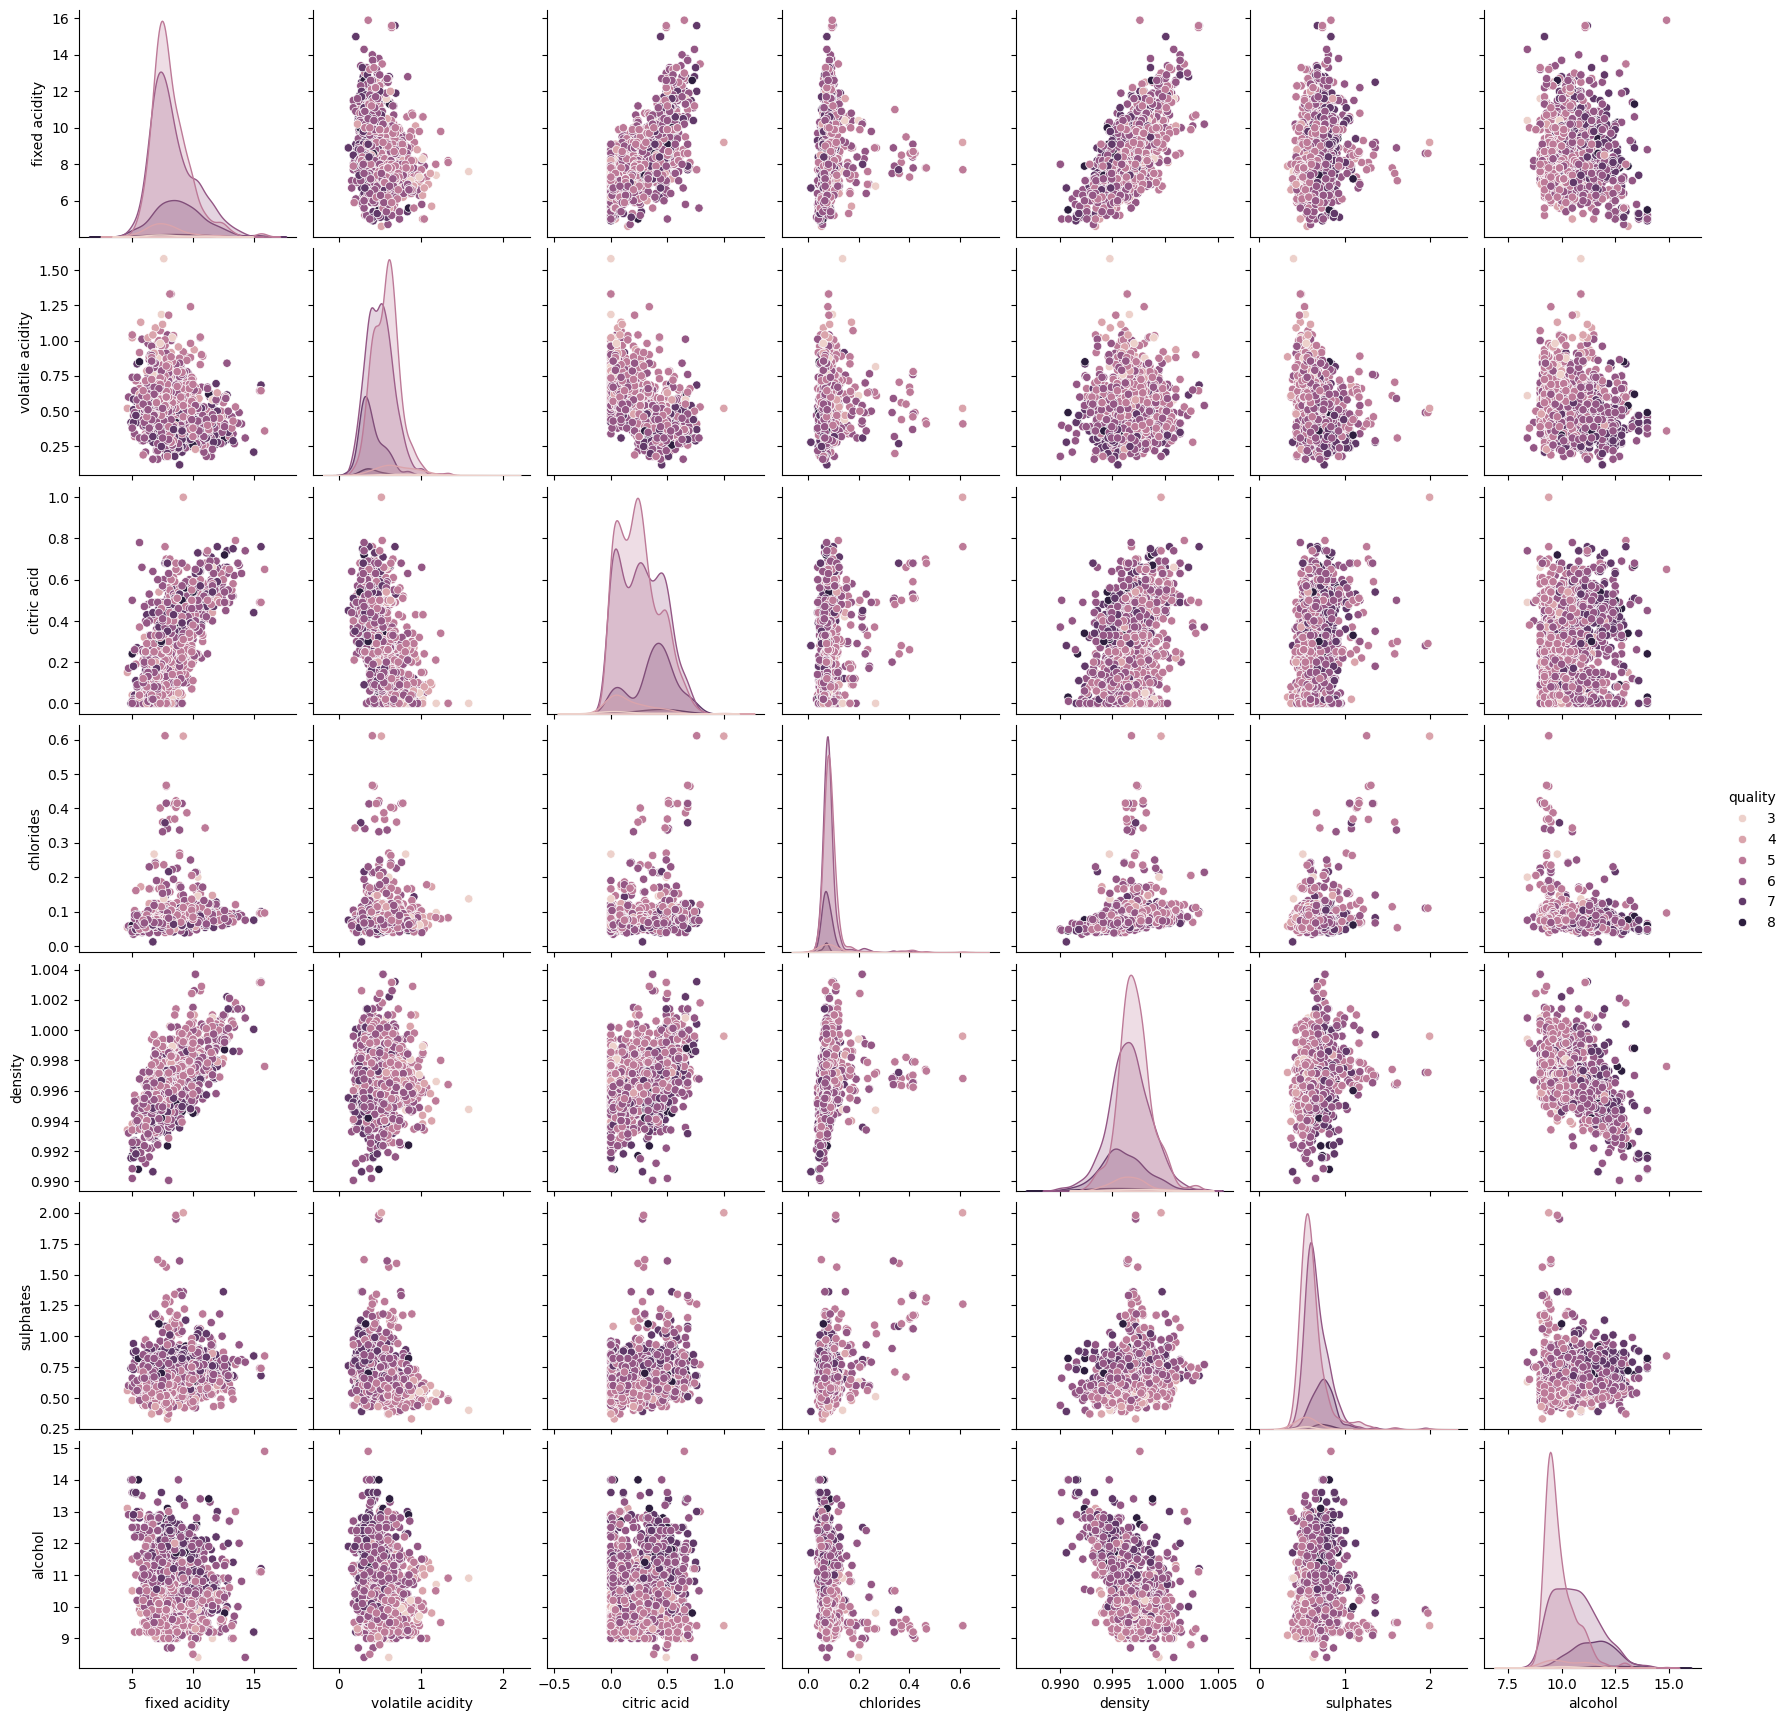

In [10]:
ax = sns.pairplot(df_train[['fixed acidity', 'volatile acidity', 'citric acid','chlorides','density','sulphates', 'alcohol','quality']], hue='quality')

### Initialization Train

In [11]:
## Separando a base de dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

#### DecisionTreeClassifier

In [12]:
model_tree = DecisionTreeClassifier(random_state=1)

param_grid_tree = { 
    'criterion': ['gini', 'entropy', 'log_loss'], 
    'splitter': ['best', 'random'],
    'max_depth': [5, 10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4] }

grid_search_tree = GridSearchCV(estimator=model_tree, param_grid=param_grid_tree, cv=5, n_jobs=-1, verbose=2)

grid_search_tree.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             verbose=2)

In [13]:
y_pred_tree = grid_search_tree.predict(X_test)

accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f"Acurácia: {accuracy_tree*100:.3f}")

Acurácia: 57.812


In [14]:
print("\nRelatório de Classificação DecisionTreeClassifier:")
print(classification_report(y_test, y_pred_tree))


Relatório de Classificação DecisionTreeClassifier:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.71      0.67      0.69       130
           6       0.58      0.58      0.58       132
           7       0.48      0.52      0.50        42
           8       0.00      0.00      0.00         5

    accuracy                           0.58       320
   macro avg       0.29      0.29      0.29       320
weighted avg       0.59      0.58      0.58       320



#### RandomForestClassifier

In [15]:
parameters = {
    'n_estimators': [100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20],
    'max_features': ['sqrt', 'log2'],
}

rf_model = RandomForestClassifier(random_state=42)
rf_cv = GridSearchCV(estimator=rf_model, cv=5, param_grid=parameters)

rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200]})

In [16]:
y_pred_rf = rf_cv.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Acurácia: {accuracy_rf*100:.3f}")

Acurácia: 66.875


In [17]:
print("\nRelatório de Classificação RandomForestClassifier:")
print(classification_report(y_test, y_pred_rf))


Relatório de Classificação RandomForestClassifier:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.72      0.78      0.75       130
           6       0.64      0.69      0.66       132
           7       0.58      0.50      0.54        42
           8       0.00      0.00      0.00         5

    accuracy                           0.67       320
   macro avg       0.32      0.33      0.33       320
weighted avg       0.63      0.67      0.65       320



#### DecisionTreeRegressor

In [18]:
model_tree_regr = DecisionTreeRegressor(random_state=42)

param_grid = { 
    'criterion': ['mse', 'friedman_mse', 'mae'], 
    'max_depth': [10, 20, 30], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4 ]}

grid_search_tree_regr = GridSearchCV(estimator=model_tree_regr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search_tree_regr.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             verbose=2)

In [19]:
y_pred_tree_regr = grid_search_tree_regr.predict(X_test)

accuracy_tree_regr = accuracy_score(y_test, y_pred_rf)
print(f"Acurácia: {accuracy_tree_regr*100:.3f}")

Acurácia: 66.875


#### KNeighborsClassifier

In [20]:
knn = KNeighborsClassifier(n_neighbors=6)

param_grid_knn = {
    'n_neighbors': [3, 5, 10, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'p': [1, 2]
}

grid_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, verbose=2)

grid_knn.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END metric=euclidean, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END metric=euclidean, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END metric=eucl

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=6),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski',
                                    'chebyshev'],
                         'n_neighbors': [3, 5, 10, 20], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [21]:
y_pred_knn = grid_knn.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Acurácia: {accuracy_knn*100:.3f}")

Acurácia: 60.938


#### XGBoost

In [22]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

class_xgb = xgb.XGBClassifier()
class_xgb.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [23]:
y_pred_xgb = class_xgb.predict(X_test)

accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print(f"Acurácia: {accuracy_xgb*100:.3f}")

Acurácia: 64.062


### Modelo Campeão RandomForestClassifier

In [24]:
# Testando o modelo com uma coluna a mais porevendo o resultado
df_train['RFClassifier_predict'] = rf_cv.predict(df_train[var_model])

In [25]:
# base de dados com a previsão do RandomForestClassifier
df_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,RFClassifier_predict
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,5


In [26]:
# Erros que foram gerados pelo modelo de RandomForestClassifier

df_train.loc[df_train['RFClassifier_predict'] != df_train['quality']]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,RFClassifier_predict
29,7.8,0.645,0.00,2.0,0.082,8.0,16.0,0.99640,3.38,0.59,9.80,6,5
59,7.3,0.390,0.31,2.4,0.074,9.0,46.0,0.99620,3.41,0.54,9.40,6,5
67,6.6,0.705,0.07,1.6,0.076,6.0,15.0,0.99620,3.44,0.58,10.70,5,6
70,7.7,0.630,0.08,1.9,0.076,15.0,27.0,0.99670,3.32,0.54,9.50,6,5
73,8.3,0.675,0.26,2.1,0.084,11.0,43.0,0.99760,3.31,0.53,9.20,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,6.7,0.760,0.02,1.8,0.078,6.0,12.0,0.99600,3.55,0.63,9.95,3,5
1523,6.8,0.480,0.25,2.0,0.076,29.0,61.0,0.99530,3.34,0.60,10.40,5,6
1525,6.7,0.480,0.08,2.1,0.064,18.0,34.0,0.99552,3.33,0.64,9.70,5,6
1529,7.1,0.690,0.08,2.1,0.063,42.0,52.0,0.99608,3.42,0.60,10.20,6,5


**Criando uma base fake para fazer alguns testes**

In [27]:
df_validation = pd.DataFrame(data=np.array([[7.8,0.750,0.03,0.073,0.99870,0.57,9.4],[7.9,0.840,0.00,0.089,0.99780,0.65,9.6],[7.7,0.790,0.04,0.086,0.99700,0.69,9.7]]), columns=['fixed acidity','volatile acidity','citric acid','chlorides','density','sulphates','alcohol'])
df_validation

,fixed acidity,volatile acidity,citric acid,chlorides,density,sulphates,alcohol
0,7.8,0.75,0.03,0.073,0.9987,0.57,9.4
1,7.9,0.84,0.00,0.089,0.9978,0.65,9.6
2,7.7,0.79,0.04,0.086,0.9970,0.69,9.7


In [28]:
df_validation['RFClassifier_predict'] = rf_cv.predict(df_validation)

In [29]:
df_validation

,fixed acidity,volatile acidity,citric acid,chlorides,density,sulphates,alcohol,RFClassifier_predict
0,7.8,0.75,0.03,0.073,0.9987,0.57,9.4,5
1,7.9,0.84,0.00,0.089,0.9978,0.65,9.6,5
2,7.7,0.79,0.04,0.086,0.9970,0.69,9.7,5


**Usando base de Teste para executar uma validação**

In [30]:
df_test['RFClassifier_predict'] = rf_cv.predict(df_test[var_model])
df_test

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,RFClassifier_predict
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,5
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,6
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,5
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,7
